In [2]:
# install pytorch 
# conda install -c pytorch pytorch
# pip3 install torch==1.9.1+cu102 torchvision==0.10.1+cu102 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
## switch to the name of your virtual environment
kernel_name = ".venv_master_project"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [5]:
import torch

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

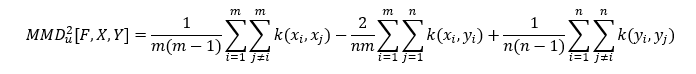

In [6]:
## the code is a combination between:
## - this forum answer: https://discuss.pytorch.org/t/maximum-mean-discrepancy-mmd-and-radial-basis-function-rbf/1875/2
## - this tutorial: https://www.kaggle.com/onurtunali/maximum-mean-discrepancy

def MMD(x, y, kernel, kernel_bandwidth):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    
    ## torch.mm performs matrix multiplication
    ## x.t() performs a transpose
    ## xx.diag() contains the square of each row/point in x
    xx, yy, xy = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    
    ## calculating the first summation of parts A and C
    # unsqueze adds another dimension to the tensor (,n) to (1,n)
    # expand_as duplicates the array to as many rows to match the array given 
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    # compute the distance matrix: (x - y)^2 = x^2 - 2*x*y + y^2
    dxx = rx.t() - 2 * xx + rx 
    dyy = ry.t() - 2 * yy + ry 
    dxy = rx.t() - 2 * xy + ry 
    
    if kernel == "multiscale":
        XX = kernel_bandwidth**2 * (kernel_bandwidth**2 + dxx)**-1
        YY = kernel_bandwidth**2 * (kernel_bandwidth**2 + dyy)**-1
        XY = kernel_bandwidth**2 * (kernel_bandwidth**2 + dxy)**-1
            
    if kernel == "rbf":
        XX = torch.exp(-0.5*dxx/kernel_bandwidth)
        YY = torch.exp(-0.5*dyy/kernel_bandwidth)
        XY = torch.exp(-0.5*dxy/kernel_bandwidth)

    m = x.size()[0]
    n = y.size()[0]
    
    return 1/(m*(m-1)) * torch.sum(XX) - 2/(m*n) * torch.sum(XY) + 1/(n*(n-1)) * torch.sum(YY)

In [39]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal 


m = 20 # sample size
x_mean = torch.zeros(2) + 1
y_mean = torch.zeros(2)
x_cov = 2 * torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3 * torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)
z = px.sample([m]).to(device)

result = MMD(x, y, kernel="rbf", kernel_bandwidth = 1)
print(f"MMD result of X and Y is {result.item()}")

result = MMD(x, z, kernel="rbf", kernel_bandwidth = 1)
print(f"MMD result of X and Z is {result.item()}")

MMD result of X and Y is 0.2206467092037201
MMD result of X and Z is 0.1529797464609146


In [57]:
## The data used are publicly available at:
### - https://archive.ics.uci.edu/ml/datasets/GNFUV+Unmanned+Surface+Vehicles+Sensor+Data+Set+2 (experiment_1 & experiment_2)
### - https://archive.ics.uci.edu/ml/datasets/GNFUV+Unmanned+Surface+Vehicles+Sensor+Data (experiment_3)

## Did some refactoring to the original data folders but you can change the code according to your system.

import pandas as pd
from csv import reader
import ast

## Each experiment has four nodes, pi2, pi3, pi4 and pi5
nodes = ["pi" + str(i) for i in range(2,6)]
## and the following attributes are recorded by the each nodes device:
### - humidity
### - temperature
### - time of the recording

## therefore each data row should record the following
attributes = ["device", "humidity", "temperature", "time", "pi", "experiment"]

experiments_data = {}

for i in range(1,4):
    experiment =  "experiment_" + str(i)
    directory = "//".join([os.getcwd(), "data", experiment])
    experiment_files = os.listdir(directory)
    data = []
    for file in experiment_files:
        name = file.split(".")[0]
        if name in nodes:
            node_directory = directory + "//" + file
            if ".csv" in file:
                with open(node_directory, 'r') as f:
                    file_data = []
                    # pass the file object to reader() to get the reader object
                    csv_reader = reader(f)
                    # Iterate over each row in the csv using reader object
                    for row in csv_reader:
                        dictionary = ast.literal_eval(",".join(row))
                        file_data.append(dictionary)
                    node_data = pd.DataFrame(file_data)
                    node_data["pi"] = name
                
            elif ".xlsx" in file:
                node_data = pd.read_excel(node_directory)
            node_data.columns= node_data.columns.str.lower()
            node_data.experiment = i
            data.append(node_data)
            
    experiments_data[experiment] = pd.concat(data).reset_index(drop=True)

In [61]:
experiments_data["experiment_1"].loc[0].time

str

In [50]:
experiments_data["experiment_3"]

,device,humidity,temperature,experiment,time,pi
0,gnfuv-temp-exp1-55d487b85b-5g2xh,21.0,40.0,3,1.522085e+09,pi2
1,gnfuv-temp-exp1-55d487b85b-5g2xh,21.0,40.0,3,1.522085e+09,pi2
2,gnfuv-temp-exp1-55d487b85b-5g2xh,21.0,40.0,3,1.522085e+09,pi2
3,gnfuv-temp-exp1-55d487b85b-5g2xh,21.0,40.0,3,1.522085e+09,pi2
4,gnfuv-temp-exp1-55d487b85b-5g2xh,22.0,40.0,3,1.522085e+09,pi2
...,...,...,...,...,...,...
573,gnfuv-temp-exp1-55d487b85b-5ztk8,24.0,34.0,3,1.522093e+09,pi5
574,gnfuv-temp-exp1-55d487b85b-5ztk8,24.0,34.0,3,1.522093e+09,pi5
575,gnfuv-temp-exp1-55d487b85b-5ztk8,NaN,NaN,3,1.522093e+09,pi5
576,gnfuv-temp-exp1-55d487b85b-5ztk8,23.0,35.0,3,1.522093e+09,pi5
